In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
#data = quandl.get('BCHARTS/BITFINEXUSD') -> OLD BUGGY DATASET (OBD)
#data = quandl.get('BITFINEX/BTCUSD')
data = quandl.get('BITFINEX/XRPBTC')
#data = quandl.get('BITFINEX/ETHBTC')

In [3]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2017-05-19,0.000200,0.000130,0.000164,0.000169,0.000159,0.000169,1.133802e+06
2017-05-20,0.000189,0.000147,0.000168,0.000168,0.000167,0.000169,4.924474e+06
2017-05-21,0.000178,0.000160,0.000163,0.000164,0.000162,0.000163,3.390939e+06
2017-05-22,0.000165,0.000115,0.000141,0.000141,0.000140,0.000141,8.063178e+06
2017-05-23,0.000159,0.000130,0.000145,0.000144,0.000143,0.000146,2.929714e+06


In [4]:
print("data shape before embedding:",data.shape)

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past we want skynet to see
d = 15

X = np.zeros((data.shape[0],d,data.shape[1]))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print("data shape after embedding:",X.shape)

data shape before embedding: (237, 7)
data shape after embedding: (222, 15, 7)


In [5]:
# creating labels
Y = data['Mid'] - data.shift(1)['Mid']

Y = Y > 0

Y.shape

(237,)

In [6]:
#removing first line: second label refers to first DP ($$ delta)
Y = Y[1:]

#removing first d days because of the embedding
Y = Y[d:]

In [7]:
#removing last registry from X, since we had to remove first DP from Y
#specifying other dimensions for good practices - TY @lucasosouza
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((221,), (221, 15, 7))

In [9]:
# Adding channel layer, as expected by the convnet
X = X.reshape((Y.shape[0],d,7,1))
X.shape

(221, 15, 7, 1)

In [10]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# split dat data 
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [11]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same so we dont lose size
    X = Conv2D(32,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(64,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    #X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(128,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(128,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(64,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(32,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [12]:
#training the model, time for witchcraft
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 130, batch_size = 8,verbose=1)

Epoch 1/130
194/194 [==============================] - 2s 9ms/step - loss: 1.3019 - acc: 0.5052
Epoch 2/130
194/194 [==============================] - 1s 6ms/step - loss: 1.2562 - acc: 0.4588
Epoch 3/130
194/194 [==============================] - 1s 6ms/step - loss: 0.8506 - acc: 0.5464
Epoch 4/130
194/194 [==============================] - 1s 7ms/step - loss: 0.8271 - acc: 0.5361
Epoch 5/130
194/194 [==============================] - 1s 7ms/step - loss: 0.7500 - acc: 0.5309
Epoch 6/130
194/194 [==============================] - 1s 6ms/step - loss: 0.7287 - acc: 0.5979
Epoch 7/130
194/194 [==============================] - 1s 7ms/step - loss: 0.6766 - acc: 0.6546
Epoch 8/130
194/194 [==============================] - 1s 7ms/step - loss: 0.7050 - acc: 0.5619
Epoch 9/130
194/194 [==============================] - 1s 6ms/step - loss: 0.6871 - acc: 0.5928
Epoch 10/130
194/194 [==============================] - 1s 7ms/step - loss: 0.7350 - acc: 0.6082
Epoch 11/130
194/194 [=================

Epoch 85/130
194/194 [==============================] - 1s 8ms/step - loss: 0.2677 - acc: 0.9278
Epoch 86/130
194/194 [==============================] - 1s 7ms/step - loss: 0.1527 - acc: 0.9381
Epoch 87/130
194/194 [==============================] - 1s 7ms/step - loss: 0.0919 - acc: 0.9433
Epoch 88/130
194/194 [==============================] - 1s 7ms/step - loss: 0.2283 - acc: 0.9278
Epoch 89/130
194/194 [==============================] - 1s 7ms/step - loss: 0.2206 - acc: 0.9278
Epoch 90/130
194/194 [==============================] - 1s 6ms/step - loss: 0.1310 - acc: 0.9330
Epoch 91/130
194/194 [==============================] - 1s 6ms/step - loss: 0.1004 - acc: 0.9433
Epoch 92/130
194/194 [==============================] - 1s 8ms/step - loss: 0.1273 - acc: 0.9536
Epoch 93/130
194/194 [==============================] - 1s 6ms/step - loss: 0.1246 - acc: 0.9433
Epoch 94/130
194/194 [==============================] - 1s 6ms/step - loss: 0.1071 - acc: 0.9433
Epoch 95/130
194/194 [========

In [13]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

27/27 [==============================] - 0s 3ms/step

Loss = 3.71977376938
Acc = 0.629629611969


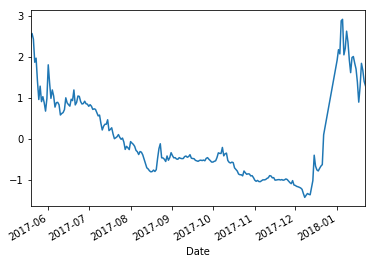

In [14]:
data['Mid'].plot()
